In [1]:
import torch
import torchaudio
import torchaudio.transforms as T

In [55]:
import os

import librosa
import matplotlib.pyplot as plt
import requests
from IPython.display import Audio, display

_SAMPLE_DIR = "_assets"

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)


def _fetch_data():
    uri = [
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    ]
    for url, path in uri:
        with open(path, "wb") as file_:
            file_.write(requests.get(url).content)


# _fetch_data()


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def get_spectrogram(
    n_fft=400,
    win_len=None,
    hop_len=None,
    power=2.0,
):
    # 获得频谱图
    waveform, sample_rate = get_speech_sample()
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform), sample_rate

def spec2waveform_griffinLim(spectrogram, hop_len = None):
    n_fft=400
    win_len=None
    # hop_len=None
    power=2.0
    griffin_lim = T.GriffinLim(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        power=power
    )
    return griffin_lim(spectrogram)

def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


# SpecAugment
频谱增强是一种流行的频谱图增强技术
主要有TimeStretch TimeMasking FrequencyMasking

## TimeStretch

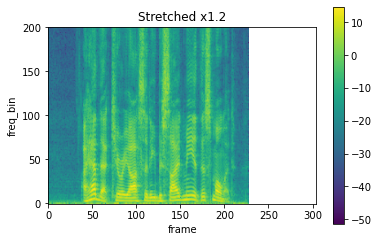

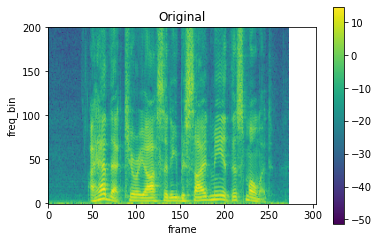

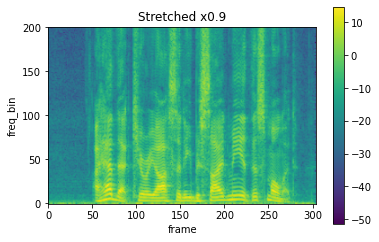

In [4]:
spec, _ = get_spectrogram(power=None)
stretch = T.TimeStretch()

rate = 1.2
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)
# 缩小了1.2倍

plot_spectrogram(torch.abs(spec[0]), title="Original", aspect="equal", xmax=304)

rate = 0.9
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)
# 扩大了1/0.9倍

原始声波信息：
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])

原始声波图： 


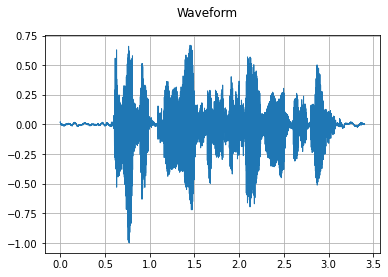

原始音频播放： 


In [11]:
origin_waveform, sample_rate = get_speech_sample()
print('原始声波信息：')
print_stats(origin_waveform)
print('原始声波图： ')
plot_waveform(origin_waveform, sample_rate)
print('原始音频播放： ')
play_audio(origin_waveform, sample_rate)


torch.Size([1, 201, 273])
频谱图信息：
Shape: (1, 201, 273)
Dtype: torch.float32
 - Max:     897.147
 - Min:      0.000
 - Mean:     2.239
 - Std Dev: 20.998

tensor([[[5.4815e+00, 1.5772e-01, 1.3105e-01,  ..., 2.1306e+00,
          6.8096e-01, 1.8927e-01],
         [3.6053e+00, 5.9546e-02, 6.1161e-02,  ..., 5.8467e-01,
          1.7731e-01, 2.2788e-02],
         [8.1372e-01, 1.4541e-01, 1.4256e-01,  ..., 1.5266e-02,
          6.5624e-03, 2.1952e-05],
         ...,
         [1.7497e-06, 7.0292e-07, 3.0349e-07,  ..., 2.7325e-07,
          3.8198e-07, 1.1340e-06],
         [6.9050e-06, 5.6465e-06, 1.2614e-06,  ..., 4.1065e-06,
          4.2960e-06, 8.7536e-08],
         [2.4680e-05, 1.9506e-05, 1.1039e-06,  ..., 4.9394e-06,
          1.5377e-06, 8.1081e-07]]])

频谱图


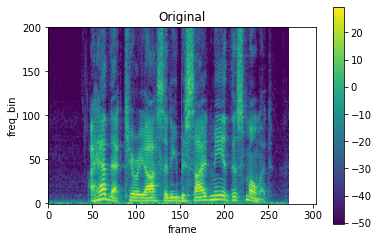

还原后的waveform: 
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.744
 - Min:     -0.812
 - Mean:     0.004
 - Std Dev:  0.124

tensor([[0.0111, 0.0115, 0.0121,  ..., 0.0043, 0.0044, 0.0039]])

还原后的waveform声波图： 


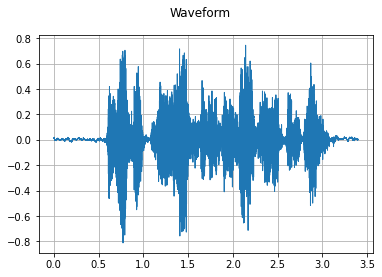

还原后的waveform音频播放： 


In [50]:
origin_spec, sample_rate = get_spectrogram(power=2.0) # 先得到频谱图
print(origin_spec.shape)
print('频谱图信息：')
print_stats(origin_spec)
print('频谱图')
plot_spectrogram(torch.abs(origin_spec[0]), title="Original", aspect="equal", xmax=304) # 绘制频谱图
print('还原后的waveform: ')
origin_waveform_from_spec = spec2waveform_griffinLim(origin_spec) # 频谱图转换为声波图
print_stats(origin_waveform_from_spec)
print('还原后的waveform声波图： ')
plot_waveform(origin_waveform_from_spec, sample_rate)
print('还原后的waveform音频播放： ')
play_audio(origin_waveform_from_spec, sample_rate)

频谱图信息：
Shape: (1, 201, 273)
Dtype: torch.float32
 - Max:     897.147
 - Min:      0.000
 - Mean:     2.239
 - Std Dev: 20.998

tensor([[[5.4815e+00, 1.5772e-01, 1.3105e-01,  ..., 2.1306e+00,
          6.8096e-01, 1.8927e-01],
         [3.6053e+00, 5.9546e-02, 6.1161e-02,  ..., 5.8467e-01,
          1.7731e-01, 2.2788e-02],
         [8.1372e-01, 1.4541e-01, 1.4256e-01,  ..., 1.5266e-02,
          6.5624e-03, 2.1952e-05],
         ...,
         [1.7497e-06, 7.0292e-07, 3.0349e-07,  ..., 2.7325e-07,
          3.8198e-07, 1.1340e-06],
         [6.9050e-06, 5.6465e-06, 1.2614e-06,  ..., 4.1065e-06,
          4.2960e-06, 8.7536e-08],
         [2.4680e-05, 1.9506e-05, 1.1039e-06,  ..., 4.9394e-06,
          1.5377e-06, 8.1081e-07]]])

torch.Size([1, 201, 228])
收缩之后的频谱图信息：
Shape: (1, 201, 228)
Dtype: torch.float32
 - Max:     864.629
 - Min:      0.000
 - Mean:     2.230
 - Std Dev: 20.245

tensor([[[5.4815e+00, 1.5239e-01, 9.8519e-01,  ..., 2.1306e+00,
          5.8262e-01, 1.1356e-01],
     

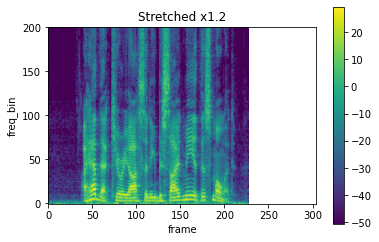

还原后的waveform: 
Sample Rate: 16000
Shape: (1, 51756)
Dtype: torch.float32
 - Max:      1.077
 - Min:     -1.093
 - Mean:     0.004
 - Std Dev:  0.128

tensor([[-0.0075, -0.0073, -0.0076,  ...,  0.0011,  0.0014,  0.0014]])

还原后的waveform声波图： 


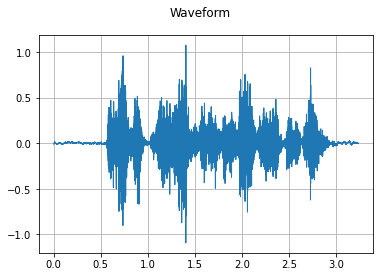

还原后的waveform音频播放： 


In [57]:
origin_spec, sample_rate = get_spectrogram(power=2.0) # 得到频谱图
print('频谱图信息：')
print_stats(origin_spec)
stretch = T.TimeStretch()
rate = 1.2
spec_of_large_times = stretch(origin_spec, rate).float() # 收缩1.2倍
print(spec_of_large_times.shape)
print('收缩之后的频谱图信息：')
print_stats(spec_of_large_times)
print('频谱图')
plot_spectrogram(torch.abs(spec_of_large_times[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304) # 绘制频谱图
print('还原后的waveform: ')
waveform_of_large_times = spec2waveform_griffinLim(spec_of_large_times, hop_len=spec_of_large_times.shape[2]) # 频谱图转换为声波图
print_stats(waveform_of_large_times, sample_rate)
print('还原后的waveform声波图： ')
plot_waveform(waveform_of_large_times, sample_rate)
print('还原后的waveform音频播放： ')
play_audio(waveform_of_large_times, sample_rate)

# TimeMasking
对时域上进行部分mask

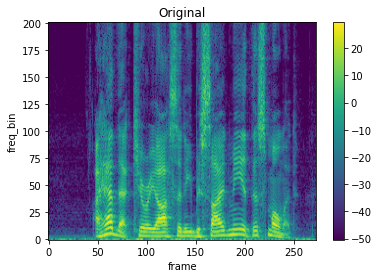

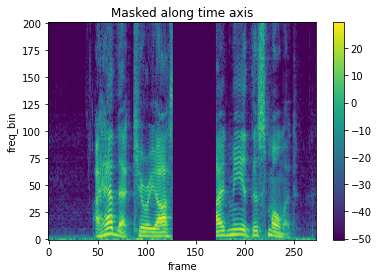

In [64]:
torch.random.manual_seed(4)

spec, _ = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.TimeMasking(time_mask_param=80)
# 最大mask长度
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along time axis")

# frequency masking
对频域进行mask

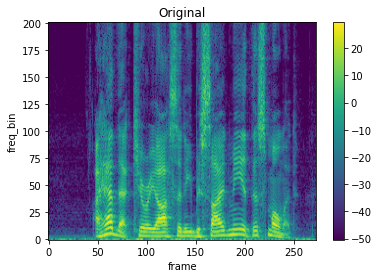

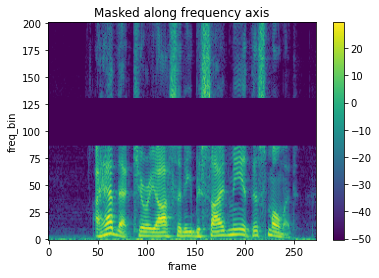

In [61]:
torch.random.manual_seed(4)

spec, _ = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.FrequencyMasking(freq_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along frequency axis")